# Курсовая работа

Подключим неоходимое для работы:

In [1]:
%matplotlib notebook

import math
from math import *
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy
import filterpy
import seaborn
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_continuous_white_noise
from filterpy.common import Q_discrete_white_noise
#import code.book_plots as bp
from scipy import stats
from filterpy.common import van_loan_discretization
from scipy.linalg import expm

Выберем необходимые геодезические константы:

In [3]:
R_earth = 6371000
a = 6378137.0
b = 6356752.0
e2 = 6.6943799901413 * (10 ** -3)
delta_t = 0.005
phi_0 = 31.2*pi/180.0          #initial latitude in radians
lambda_0 = 121.3*pi/180.0      #initial longitude in radians
h_0 = 4                        #initial altitude in meters
u = 2 * pi / 86164.090530833

Переведём данные в удобный для работы формат и далее сохраним их в пикл (чтобы можно было быстро работать с этой структурой данных):

In [4]:
def CNFparser(filename):
    '''
    Тут мы расписываем парсер
    CNFnav - кусок для работы в режиме навигации
    CNFalign - кусок для выставки (причём секунд 10-20 из него для алгебраической, остальное на кинематику)
    '''
    CNFnames = ['Time','AccX','AccY','AccZ','OmX','OmY','OmZ']
    CNF = pd.read_table(filename, sep = '\s+' ,header = None, names = CNFnames)
    #CNFalign = CNF[CNF.FlagAlignment == 1]
    #CNFalign = CNFalign.loc[:,['Time','OmX','OmY','OmZ','AccX','AccY','AccZ']]
    #CNFnav = CNF[CNF.FlagAlignment == 0]
    #CNFnav = CNFnav.loc[:,['Time','OmX','OmY','OmZ','AccX','AccY','AccZ']]
    #CNF = []
    CNF['Invariant'] = CNF.AccX*CNF.OmX +  CNF.AccY*CNF.OmY +  CNF.AccZ*CNF.OmZ
    CNF['g\''] = (CNF.AccX**2 + CNF.AccY**2 + CNF.AccZ**2)**(0.5)
    CNF['W_Std500'] = (CNF.Invariant.rolling(window = 500, center = False).std()).dropna()
    return CNF

Считаем данные:

In [5]:
CNF = CNFparser('IMU_coursework.txt')

In [6]:
CNF.to_pickle('IMU_df.pkl')

In [5]:
CNF = pd.read_pickle('IMU_df.pkl')

Исследуем данные:

Интенсивность шума на всём интервале времени одинаковая:

<IPython.core.display.Javascript object>


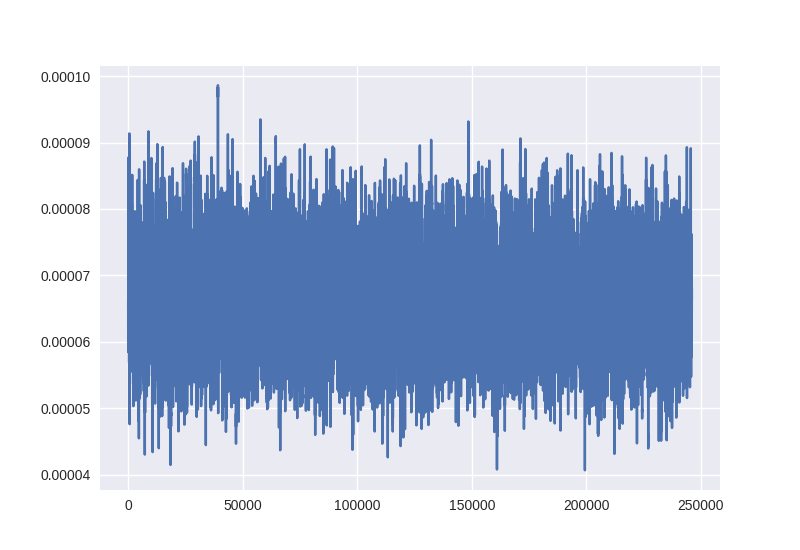

In [11]:
plt.plot(CNF.Invariant.rolling(window = 50, center = False).std()[:])

А тут видно начало движения:

<IPython.core.display.Javascript object>


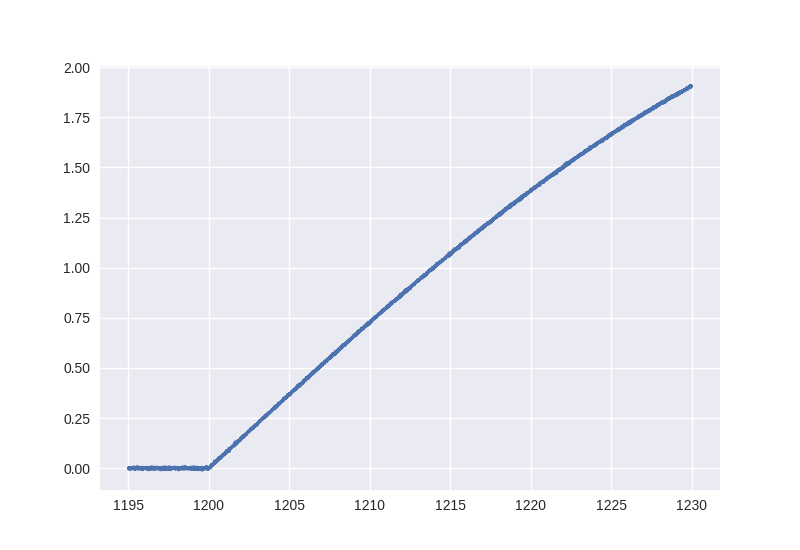

In [12]:
plt.plot(CNF.Time[239000:],CNF.AccY[239000:])

<IPython.core.display.Javascript object>


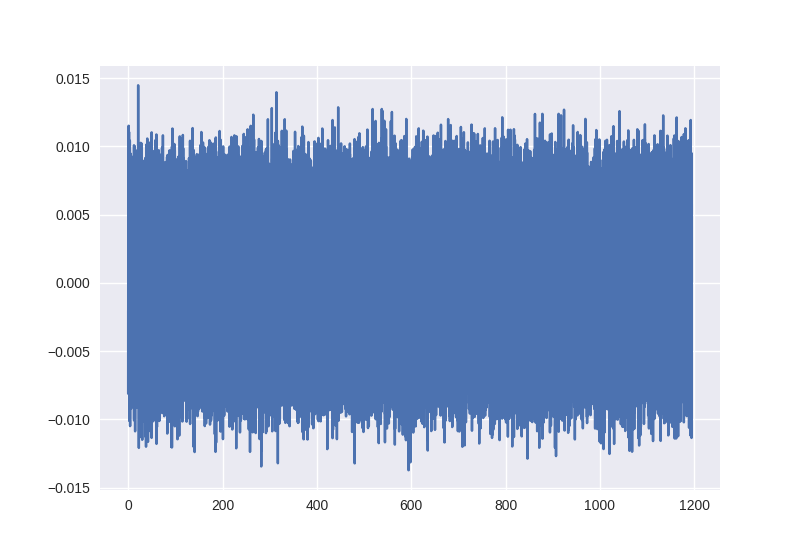

In [13]:
plt.plot(CNF.Time[:239000],CNF.AccY[:239000])

Реализуем формулу Гельмерта:

In [14]:
def g_phi(phi, h, a, e2):
    #g1 = 9.78030 * (1 - 2 * h / a + 3 * e2 * sin(phi) ** 2 / 4)
    g = 9.78030*(1+0.005302*sin(phi)*sin(phi)-0.000007*sin(2*phi)*sin(2*phi))
    return g#(f_x**2 + f_y**2 + f_z**2)**(0.5) #

In [15]:
g_phi(phi_0, h_0, a, e2)


9.79416166528857

Сравним со средним значением силы тяжести:

In [29]:
temp = np.mean(CNF.loc[:2000,['AccX','AccY','AccZ','OmX','OmY','OmZ']].values, axis = 0).reshape(6,1)
print 'g\' = ', np.linalg.norm(temp[0:3])
print '\delta g = ', np.linalg.norm(temp[0:3]) - g_phi(phi_0, h_0, a, e2)
del temp

g' =  9.79400326601
\delta g =  -0.000158399275357


Делаем вывод, что данная реализация формулы Гельмерта работает корректно.

Выделим часть данных для начальной выставки, примерно первые 10 секунд. С шагом дискретизации в 0.005 секунды это будет 2000 измерений:

In [40]:
CNFinit = CNF.loc[:1999,['Time','AccX','AccY','AccZ','OmX','OmY','OmZ']].values

Реализуем функцию начальной алгебраической выставки для получения матрицы ориентации L и функцию перевычисления матрицы ориентации по значениям углов ориентации приборного трехгранника относительно географической системы координат:

In [65]:
def initial_calibration(A, phi, h, a, e2, u):
    L = np.zeros((3, 3))
    means = np.mean(A[:, 1:], axis = 0).reshape(6,1)
    theta = math.atan2(means[0], math.sqrt(means[1]**2+means[2]**2))
    gamma = -math.atan2(means[2], means[1])
    L[:, 2:3] = np.array([sin(theta),cos(theta)*cos(gamma),-cos(theta)*sin(gamma)]).reshape(3,1)
    L[:, 1:2] = (means[3:6] - (L[:, 2:3] * u * sin(phi))) / (u * cos(phi))
    L[:, 1:2] /= np.linalg.norm(L[:, 1:2], 2) 
    L[:, 0:1] = np.cross(L[:, 1:2].T, L[:, 2:3].T).T
    psi = math.atan2(L[0][0], L[0][1])
    #L[:, 2:3] /= np.linalg.norm(L[:, 2:3], 2) 
    #L[:, 0:1] /= np.linalg.norm(L[:, 0:1], 2)
    return L, theta, gamma, psi

In [76]:
def L_create(theta, gamma, psi):
    L = np.array([[sin(psi)*cos(theta), cos(psi)*cos(theta), sin(theta)],
         [cos(psi)*sin(gamma)-sin(psi)*sin(theta)*cos(gamma), -sin(psi)*sin(gamma)-cos(psi)*sin(theta)*cos(gamma), cos(theta)*cos(gamma)],
         [cos(psi)*cos(gamma)+sin(psi)*sin(theta)*sin(gamma), -sin(psi)*cos(gamma)+cos(psi)*sin(theta)*sin(gamma), -cos(theta)*sin(gamma)]])
    return L.reshape((3,3))

In [67]:
L_0, theta, gamma, psi  = initial_calibration(CNFinit, phi_0, h_0, a, e2, u)
print L_0, np.linalg.det(L_0)

[[  9.91346955e-01  -1.31056370e-01   3.97769647e-06]
 [  1.31056340e-01   9.91346899e-01   7.51154467e-06]
 [ -4.92771284e-06  -7.45345149e-03   1.00000000e+00]] 0.999944549247


Наивный алгоритм отработал хорошо и дал хорошее значение определителя.

Реализуем чуть менее наивный алгоритм по результатам первой курсовой:

In [68]:
def initial_calibration_naive(A, phi, h, a, e2, u):
    L = np.zeros((3, 3))
    means = np.mean(A[:, 1:], axis = 0).reshape(6,1)
    theta = math.atan2(means[0], math.sqrt(means[1]**2+means[2]**2))
    gamma = -math.atan2(means[2], means[1])
    L[:, 2:3] = means[0:3] / g_phi(phi, h, a, e2)
    L[:, 1:2] = (means[3:6] - (L[:, 2:3] * u * sin(phi))) / (u * cos(phi))
    L[:, 0:1] = np.cross(L[:, 1:2].T, L[:, 2:3].T).T
    L[:, 2:3] /= np.linalg.norm(L[:, 2:3], 2)
    L[:, 1:2] /= np.linalg.norm(L[:, 1:2], 2)
    L[:, 0:1] /= np.linalg.norm(L[:, 0:1], 2)
    psi = math.atan2(L[0][0], L[0][1])
    return L, theta, gamma, psi

In [69]:
L_0, theta, gamma, psi  = initial_calibration_naive(CNFinit, phi_0, h_0, a, e2, u)
print L_0, np.linalg.det(L_0)
print theta, gamma, psi

[[  9.91374441e-01  -1.31056380e-01   3.97769647e-06]
 [  1.31059974e-01   9.91346972e-01   7.51154467e-06]
 [ -4.92784947e-06  -7.44359458e-03   1.00000000e+00]] 0.999972347592
3.97769647237e-06 -1.57078881525 1.70223086418


In [79]:
X = L_create(theta, gamma, psi)
print X,  np.linalg.det(X)

[[  9.91374908e-01  -1.31056441e-01   3.97769647e-06]
 [  1.31056441e-01   9.91374908e-01   7.51154467e-06]
 [ -4.92782479e-06  -6.92545417e-06   1.00000000e+00]] 1.0


Отлично, всё работает как надо и отловлены все ошибки и опечатки. Проверим корректность вводимой информации о широте:

In [105]:
def phi_initialize(A, theta, gamma):
    omega = np.mean(A[:, 4:], axis = 0).reshape(3,1)
    B = np.array([[0,          sin(gamma),             cos(gamma)],
                 [cos(theta), -sin(theta)*cos(gamma),  sin(theta)*sin(gamma)],
                 [sin(theta),  cos(theta)*cos(gamma), -cos(theta)*sin(gamma)]])
    omega_x = np.dot(B, omega)
    phi = math.atan2(omega_x[2], math.sqrt(omega_x[0]**2 + omega_x[1]**2))
    psi = -math.atan2(omega_x[0],omega_x[1])
    return phi, psi

In [106]:
print phi_initialize(CNFinit, theta, gamma)

(0.5393003838952278, 1.702234427718291)


In [107]:
print phi_0, psi

0.544542726622 1.70223086418


In [49]:
dist = getattr(scipy.stats,'norm')
param = CNF.OmX.loc[:240000]
print param

0        -8.114000e-06
1        -8.114000e-06
2        -1.531100e-05
3        -1.634700e-05
4         1.593000e-06
5        -1.126800e-05
6        -1.808000e-05
7        -7.390000e-06
8        -7.297000e-06
9        -6.035000e-06
10       -9.518000e-06
11       -1.387500e-05
12       -6.969000e-06
13       -3.179000e-06
14       -6.024000e-06
15       -5.774000e-06
16       -9.459000e-06
17       -4.731000e-06
18        7.870000e-06
19       -7.753000e-06
20       -1.721500e-05
21       -5.670000e-07
22       -6.200000e-06
23       -1.346100e-05
24       -1.966900e-05
25       -1.982400e-05
26       -6.730000e-06
27       -2.675000e-06
28       -3.521000e-06
29        2.799000e-06
              ...     
239971   -1.497800e-05
239972   -9.850000e-07
239973   -1.638100e-05
239974   -2.050500e-05
239975    2.015000e-06
239976   -5.468000e-06
239977   -8.199000e-06
239978   -1.813700e-05
239979   -3.071000e-06
239980    3.881000e-06
239981   -5.385000e-06
239982   -2.286700e-05
239983   -1

In [55]:
y = CNF.OmX.loc[:1000].values
h = plt.hist(y, bins=range(100), color='w')
size = 30000
x = scipy.arange(size)
dist_names = ['gamma', 'beta', 'rayleigh', 'norm', 'pareto']

for dist_name in dist_names:
    dist = getattr(scipy.stats, dist_name)
    param = dist.fit(y)
    pdf_fitted = dist.pdf(x, *param[:-2], loc=param[-2], scale=param[-1]) * size
    plt.plot(pdf_fitted, label=dist_name)
    #plt.xlim(0,47)
plt.legend(loc='upper right')
plt.show()

/home/alexander/.local/lib/python2.7/site-packages/scipy/stats/_continuous_distns.py:407: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*sqrt(a + b + 1) / (a + b + 2) / sqrt(a*b)
/home/alexander/.local/lib/python2.7/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [63]:
scipy.stats.describe(CNF.AccY.loc[:240000].values, axis=0, ddof=1, bias=True, nan_policy='propagate')

DescribeResult(nobs=240001, minmax=(-0.013717446999999999, 0.014481306999999999), mean=-6.1611683159653498e-06, variance=1.1212318348762786e-05, skewness=-0.004983132368712765, kurtosis=-0.08117916572836137)

<IPython.core.display.Javascript object>


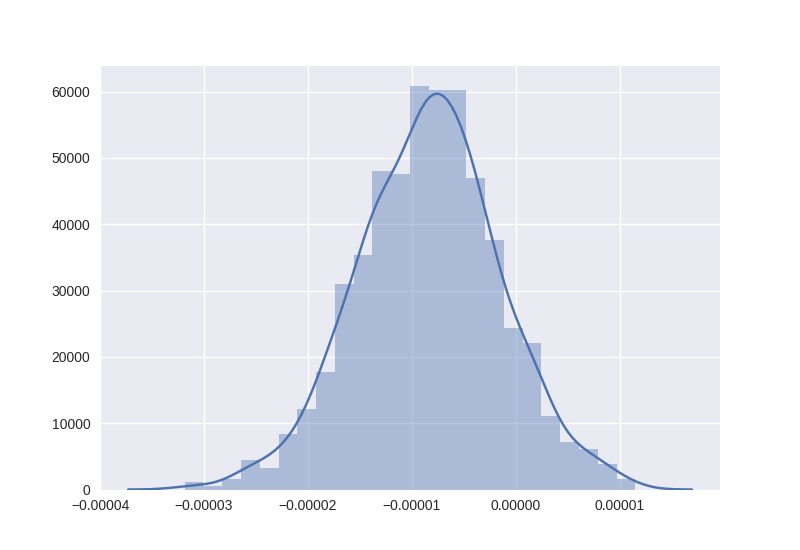

In [58]:
seaborn.distplot(CNF.OmX.loc[:1000].values)

Выполним руками:

In [163]:
CNF.OmY.loc[:240000].mean()

Time         600.000000
AccX           0.000014
AccY          -0.000006
AccZ           9.794006
OmX           -0.000008
OmY            0.000062
OmZ            0.000037
Invariant      0.000365
g'             9.794007
W_Std500       0.000067
dtype: float64

In [ ]:
om_y = CNFnav['OmY'][DELIMITER0:DELIMITER].mean()  
om_z = CNFnav['OmZ'][DELIMITER0:DELIMITER].mean()
f_x = CNFnav['AccX'][DELIMITER0:DELIMITER].mean()
f_y = CNFnav['AccY'][DELIMITER0:DELIMITER].mean()
f_z = CNFnav['AccZ'][DELIMITER0:DELIMITER].mean()

In [10]:
    om_x = CNF.OmX.loc[:230000].mean()
    om_y = CNF.OmY.loc[:230000].mean()  
    om_z = CNF.OmZ.loc[:230000].mean()
    f_x = CNF.AccX.loc[:230000].mean()
    f_y = CNF.AccY.loc[:230000].mean()
    f_z = CNF.AccZ.loc[:230000].mean()

In [188]:
print (om_x**2 + om_y**2 + om_z**2)**(0.5) #- 0.000072921158553
print (f_x**2 + f_y**2 + f_z**2)**(0.5) - g_phi(phi_0, h_0, a, e2)

-3.5589482315e-07
0.0114638210749


In [24]:
def InitialAlgebraicAlignment():
    global g
    global L
    global theta, gamma, phi, psi, psi_al, theta_al, gamma_al, L_al
    DELIMITER0 = 29986  #начало интервала наименьшего вибрационного воздействия
    DELIMITER = 50004   #конец периода наименьшего вибрационного воздействия (получены на первой курсовой)
    u = 0.000072921158553
    Pi = 3.14159265358979323846
    om_x = CNF.OmX.loc[:240000].mean()
    om_y = CNF.OmY.loc[:240000].mean()  
    om_z = CNF.OmZ.loc[:240000].mean()
    f_x = CNF.AccX.loc[:240000].mean()
    f_y = CNF.AccY.loc[:240000].mean()
    f_z = CNF.AccZ.loc[:240000].mean()
    theta = math.atan2(f_x, math.sqrt(f_y*f_y+f_z*f_z))
    gamma = -math.atan2(f_z, f_y)
    phi = 31.2
    g = 9.78030*(1+0.005302*sin(phi)*sin(phi)-0.000007*sin(2*phi)*sin(2*phi))
    om = math.sqrt(om_x*om_x+om_y*om_y+om_z*om_z)
    l13 = sin(theta)
    l23 = cos(theta)*cos(gamma)
    l33 = -cos(theta)*sin(gamma)
    l12 = (om_x - u*l13*sin(phi))/(u*cos(phi))
    l22 = (om_y - u*l23*sin(phi))/(u*cos(phi))
    l32 = (om_z - u*l33*sin(phi))/(u*cos(phi))
    l12 = l12/(sqrt(l12*l12+l22*l22+l32*l32)) #нормировка
    l22 = l22/(sqrt(l12*l12+l22*l22+l32*l32))
    l32 = l32/(sqrt(l12*l12+l22*l22+l32*l32))
    #теперь нужно векторно умножить второй на третий
    l11 = l22*l33 - l32*l23
    l21 =-l12*l33 + l13*l32
    l31 = l12*l23 - l22*l13
    L = np.matrix([[l11, l12, l13], [l21, l22, l23], [l31, l32, l33]])   #записали в матрицу
    psi = math.atan2(L.item(0,0),L.item(0,1))
    theta = math.asin(L.item(0,2))
    gamma = -math.atan2(L.item(2,2),L.item(1,2))
    psi_al = psi                                      
    theta_al = theta
    gamma_al = gamma
    L_al = L
    return L_al

In [25]:
L_1 = InitialAlgebraicAlignment()
print L_1, np.linalg.det(L_1)
print L_0, np.linalg.det(L_0)

[[  7.55974058e-01  -1.01044679e-01   1.46150649e-06]
 [  1.01045699e-01   7.55973619e-01  -6.29075429e-07]
 [ -1.04129563e-06   6.97856528e-01   1.00000000e+00]] 0.581707009351
[[  9.91163697e-01  -1.01105784e-01   1.46150649e-06]
 [  1.32644361e-01   7.55503403e-01  -6.29075429e-07]
 [ -1.36514887e-06   6.47296091e-01   1.00000000e+00]] 0.762239186546


In [168]:
print np.linalg.det(L)

0.581707009351


In [147]:
print L_0

[[ -9.91163697e-01   1.46150514e-06  -1.13770529e-01]
 [ -1.32644361e-01  -6.29065369e-07   8.50137307e-01]
 [  1.36514887e-06   1.00000000e+00   5.14123356e-01]]


In [148]:
print np.linalg.det(L_0)

0.857716675435


In [68]:
L = np.zeros((3, 3))

In [134]:
A = CNF.loc[:240000,['Time','AccX','AccY','AccZ','OmX','OmY','OmZ']].values

In [142]:
means = np.mean(A[:, 1:], axis = 0)

In [143]:
print means

[  1.43140028e-05  -6.16116832e-06   9.79400567e+00  -8.25578845e-06
   6.16904379e-05   3.73074969e-05]


In [98]:
L[:,2:3] = means[3:] / g_phi(phi_0, h_0, a, e2)

In [89]:
L = np.linspace(1, 9, num = 9).reshape(3,3)
L

array([[ 1.,  2.,  3.],
       [ 4.,  5.,  6.],
       [ 7.,  8.,  9.]])

In [87]:
L[:,2:3]

array([[ 3.],
       [ 6.],
       [ 9.]])

In [101]:
L[:, 1:2]

array([[ 2.],
       [ 5.],
       [ 8.]])

In [104]:
L[:, 1:2] = (means[0:3] - (L[:, 2:3] * u * sin(phi_0))) / (u * cos(phi_0))

In [120]:
L

array([[ -8.67116173e-01,   2.00974562e-01,  -8.43930929e-07],
       [ -1.16043431e-01,  -8.62621403e-02,   6.30617959e-06],
       [  1.19458240e-06,   1.37502561e+05,   3.81368658e-06]])

In [119]:
L[:, 0:1] = np.cross(L[:, 1:2].T, L[:, 2:3].T).T

In [122]:
L[:, 2:3] /= np.linalg.norm(L[:, 2:3], 2)